# Consumer Knowledge and Understanding

This section explores how consumer knowledge and understanding influence the adoption of electric vehicles (EVs) in France.
Survey data was analyzed to understand the relations between :

- **Self-assessed understanding**  
  (Perceived ease of use, clarity of practical aspects such as charging, autonomy, and maintenance)
- **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)
- **Objective and subjective knowledge**  
  (Self-rated knowledge of EV models and infrastructure, number of financial aids known)
- **Experience and familiarity with EVs**  
  (Driving or riding in an EV, practical understanding, perceived ease of use)
- **Link between knowledge/experience and adoption intent**  
  (Correlation between knowledge, experience, and willingness to adopt)
- **Influence of user profile**  
  (Differences in knowledge and experience by age group and location)

## Setup

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from scipy.stats import chi2_contingency
import re
from scipy.stats import kruskal
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import spearmanr
from IPython.display import display
from scipy.stats import pearsonr
from wordcloud import WordCloud, STOPWORDS

In [47]:
def extract_after_newline_parentheses(col):
    match = re.search(r'\n\s*\((.*?)\)', col)
    if match:
        return match.group(1)
    match = re.search(r'\(([^()]*(?:\([^)]*\)[^()]*)*)\)\s*$', col)
    if match:
        return match.group(1)
    return None

def extract_before_newline_parentheses(col):
    match = re.search(r'^(.*?)\s*\n', col)
    if match:
        return match.group(1)
    match = re.search(r'^(.*?)\s*\(', col)
    if match:
        return match.group(1)
    return col
def get_labels_and_title(cols):
    labels = [extract_after_newline_parentheses(col) for col in cols]
    title = extract_before_newline_parentheses(cols[0])
    return labels, title



In [48]:
df = pd.read_csv(r'FinalEvAdoptionInFranceResults.csv')
# for col in df.columns:
#     values = df[col].dropna().astype(str)
#     split_vals = []
#     for val in values:
#         split_vals.extend([v.strip() for v in val.split(',') if v.strip()])
#     unique_vals = pd.unique(split_vals)
#     if len(unique_vals) <= 20:
#         print(f"Colonne: {col}\nRéponses possibles ({len(unique_vals)}): {unique_vals[:20]}")
#         if len(unique_vals) > 20:
#             print("... (troncature à 20 valeurs)")
#         print("-" * 60)
# print(list(df.columns))

In [49]:
# Création des colonnes de base pour l'analyse


df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)

# Région (origine géographique)
region_col = [col for col in df.columns if "Habitez-vous dans" in col][0]
df['region'] = df[region_col]

# Tranche d'âge
age_col = [col for col in df.columns if "tranche d’âge" in col][0]
df['age_group'] = df[age_col]

# Nombre de véhicules et de personnes (déjà présents mais on s'assure de leur type)
df['nb_vehicules'] = pd.to_numeric(df['Combien de véhicules personnels utilisez-vous dans votre foyer ?'], errors='coerce')
df['nb_personnes'] = pd.to_numeric(df['Combien êtes-vous dans votre foyer ?'], errors='coerce')

vehicle_cols = [
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Essence ou Diesel)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride non rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Hybride rechargeable)',
    'Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)',
]
driving_exp_col = "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Un véhicule électrique correspondrait à mon mode de vie actuel]"

# Recodage échelle 4 points
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Tout à fait d'accord": 4,
    "Tout à fait d’accord": 4,  # gestion des accents différents
}
df['intention_adopter'] = df["Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"].map(likert_map)
repurchase_col = "Diriez-vous que : [En tant qu'utilisateur d'un véhicule électrique, vous en reprendrez un lors de votre prochain changement de véhicule]"
df[driving_exp_col + "_score"] = df[driving_exp_col].map(likert_map)
df['repurchase_score'] = df[repurchase_col].map(likert_map)


exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
connaissance_col = "À quel point diriez-vous que vous connaissez bien les offres actuelles de véhicules électriques et d'infrastructures associées ?"

# Recodage expérience : 1 = Oui, 0 = Non
df['exp_ev'] = df[exp_col].map({'Oui, j’ai conduit': 3,'Oui, j’étais passager': 2,'Non, jamais': 1})


connaissance_map = {
        "Pas du tout, je ne m’y suis jamais vraiment intéressé": 1,
        "Un peu, je connais quelques modèles et options": 2,
        "Assez bien, je vois passer des informations": 3,
        "Très bien, je suis régulièrement les nouveautés": 4
    }
df['connaissance_score'] = df[connaissance_col].map(connaissance_map)

aides_col = "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"
def count_aides(cell):
    if pd.isna(cell) or not cell.strip():
        return 0
    return len([aide.strip() for aide in cell.split(',') if aide.strip() and aide.strip().lower() != "aucune"])

df['score_aides_connues'] = df[aides_col].apply(count_aides)
stopwords = set(STOPWORDS)


C:\Users\Mango\AppData\Local\Temp\ipykernel_43532\2005884872.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['owns_ev'] = df["Quels types de véhicules possédez vous dans votre foyer (plusieurs réponses possibles) \n (Électrique)"].fillna(False).astype(bool)


## **Self-assessed understanding**  
  (Perceived ease of use, clarity of practical aspects such as charging, autonomy, and maintenance)

In [50]:
# 1. Statistiques descriptives sur la compréhension auto-déclarée
comprehension_cols = [
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]",
]
# 1. Extraction des types de bornes connues (multi-réponses)
bornes_col = "Avez-vous connaissance de bornes de recharge accessibles près de chez vous ?"
df[bornes_col] = df[bornes_col].astype(str)
# Oui, c'est utile ici pour extraire toutes les modalités uniques de bornes connues
all_answers = df[bornes_col].dropna().apply(lambda x: [ans.strip() for ans in x.split(',') if ans.strip() and ans.lower() != 'nan'])
flat_answers = [item for sublist in all_answers for item in sublist]
modalites = sorted(set(flat_answers))
# Création de colonnes binaires pour chaque modalité
for mod in modalites:
    df[f"borne_{mod}"] = df[bornes_col].str.contains(mod, regex=False).astype(int)

# Statistiques descriptives
for mod in modalites:
    print(f"{mod} : {df[f'borne_{mod}'].mean()*100:.1f}% des répondants")

# Croisement avec la localisation
geo_col = "Habitez-vous dans :"
for mod in modalites:
    cross = pd.crosstab(df[geo_col], df[f"borne_{mod}"], normalize='index')
    print(f"\nRépartition '{mod}' par zone :")
    print((cross*100).round(1))
for col in comprehension_cols:
    print(f"\n{col}")
    print(df[col].value_counts(dropna=False))
    # Map Likert responses to numeric if needed
    if df[col].dtype == object:

        col_num = df[col].map(likert_map)
    else:
        col_num = df[col]
    print(f"Moyenne: {col_num.mean():.2f} | % d'accord (>=4): {(col_num>=4).mean()*100:.1f}%")
    

Non : 23.7% des répondants
Oui : 77.2% des répondants
des bornes "privées" (Supermarché : 51.3% des répondants
des bornes publiques : 47.4% des répondants
je n'en vois pas : 23.7% des répondants
lieu de travail...) : 51.3% des répondants
résidence...) : 19.4% des répondants
à domicile (maison : 19.4% des répondants

Répartition 'Non' par zone :
borne_Non                0     1
Habitez-vous dans :             
Une grande ville      72.6  27.4
Une ville moyenne     77.1  22.9
Une zone périurbaine  76.6  23.4
Une zone rurale       83.9  16.1

Répartition 'Oui' par zone :
borne_Oui                0     1
Habitez-vous dans :             
Une grande ville      27.4  72.6
Une ville moyenne     21.4  78.6
Une zone périurbaine  21.3  78.7
Une zone rurale       16.1  83.9

Répartition 'des bornes "privées" (Supermarché' par zone :
borne_des bornes "privées" (Supermarché     0     1
Habitez-vous dans :                                
Une grande ville                         54.8  45.2
Une ville m

### Home Charging Availability by Area

| Area Type         | No Home Charging (%) | Home Charging (%) |
|-------------------|---------------------|-------------------|
| Large city        | 75.0                | 25.0              |
| Medium city       | 85.7                | 14.3              |
| Suburban area     | 76.6                | 23.4              |
| Rural area        | 90.3                | 9.7               |

- **Interpretation:**  
  Home charging ("at home (house)") is most common in large cities (25%) and suburban areas (23.4%), less so in medium cities (14.3%), and least common in rural areas (9.7%).

---

### Self-Assessed Understanding of Electric Vehicles

**Perceived ease of use**  
*"I feel that an electric vehicle is easy to use"*

| Response                | Count |
|-------------------------|-------|
| Somewhat agree          | 113   |
| Totally agree           | 68    |
| Somewhat disagree       | 16    |
| Totally disagree        | 2     |
| NaN                     | 33    |

- **Mean score:** 3.24 (out of 4)
- **% fully agree (score ≥ 4):** 29.3%

---

**Clarity of practical aspects**  
*"The practical aspects of an electric vehicle are clear to me (e.g., charging, range, maintenance)"*

| Response                | Count |
|-------------------------|-------|
| Somewhat agree          | 86    |
| Totally agree           | 39    |
| Somewhat disagree       | 58    |
| Totally disagree        | 16    |
| NaN                     | 33    |

- **Mean score:** 2.74 (out of 4)
- **% fully agree (score ≥ 4):** 16.8%

---

**Summary:**  
While a majority of respondents feel that electric vehicles are easy to use (mean = 3.24), fewer feel that the practical aspects are fully clear to them (mean = 2.74). The proportion who "totally agree" is notably lower for practical understanding (16.8%) than for ease of use (29.3%). Home charging is not more common in rural areas; it is actually most frequently cited in large cities and suburban areas.

## **Charging access and awareness**  
  (Knowledge of charging stations near home, access to private parking, and familiarity with charging operators)

In [51]:
for col in comprehension_cols:
    print(f"\n{col}")
    for mod in modalites:
        mean = df.groupby(f"borne_{mod}")[col].value_counts(normalize=True)
        print(f"  {mod} :\n{mean}")


Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?
 [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
  Non :
borne_Non  Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]
0          Plutôt d'accord                                                                                                                                                                              0.572414
           Tout à fait d'accord                                                                                                                                                                         0.337931
           Plutôt en désaccord                                                                                                                                                                 

### Perceived Ease of Use and Practical Understanding by Charging Point Awareness

#### **Perceived Ease of Use**
*"I feel that an electric vehicle is easy to use"*

For each type of charging point known, the table below shows the proportion of respondents (by row: 0 = does **not** know this type, 1 = **does** know this type) who selected each response:

| Charging Point Type      | Knows? | Somewhat agree | Totally agree | Somewhat disagree | Totally disagree |
|-------------------------|--------|---------------|---------------|-------------------|-----------------|
| **No**                  | 0      | 57.2%         | 33.8%         | 9.0%              | 0.0%            |
|                         | 1      | 55.6%         | 35.2%         | 5.6%              | 3.7%            |
| **Yes**                 | 0      | 55.8%         | 34.6%         | 5.8%              | 3.8%            |
|                         | 1      | 57.1%         | 34.0%         | 8.8%              | 0.0%            |
| **Private (Supermarket)**| 0     | 61.2%         | 29.1%         | 7.8%              | 1.9%            |
|                         | 1      | 52.1%         | 39.6%         | 8.3%              | 0.0%            |
| **Public**              | 0      | 55.1%         | 35.5%         | 7.5%              | 1.9%            |
|                         | 1      | 58.7%         | 32.6%         | 8.7%              | 0.0%            |
| **I don't see any**     | 0      | 57.2%         | 33.8%         | 9.0%              | 0.0%            |
|                         | 1      | 55.6%         | 35.2%         | 5.6%              | 3.7%            |
| **Workplace**           | 0      | 61.2%         | 29.1%         | 7.8%              | 1.9%            |
|                         | 1      | 52.1%         | 39.6%         | 8.3%              | 0.0%            |
| **Residence**           | 0      | 60.0%         | 31.4%         | 7.4%              | 1.1%            |
|                         | 1      | 33.3%         | 54.2%         | 12.5%             | 0.0%            |
| **At home (house)**     | 0      | 60.0%         | 31.4%         | 7.4%              | 1.1%            |
|                         | 1      | 33.3%         | 54.2%         | 12.5%             | 0.0%            |

#### **Clarity of Practical Aspects**
*"The practical aspects of an electric vehicle are clear to me (e.g., charging, range, maintenance)"*

| Charging Point Type      | Knows? | Somewhat agree | Totally agree | Somewhat disagree | Totally disagree |
|-------------------------|--------|---------------|---------------|-------------------|-----------------|
| **No**                  | 0      | 44.8%         | 20.7%         | 27.6%             | 6.9%            |
|                         | 1      | 38.9%         | 16.7%         | 33.3%             | 11.1%           |
| **Yes**                 | 0      | 38.5%         | 17.3%         | 32.7%             | 11.5%           |
|                         | 1      | 44.9%         | 20.4%         | 27.9%             | 6.8%            |
| **Private (Supermarket)**| 0     | 43.7%         | 14.6%         | 29.1%             | 12.6%           |
|                         | 1      | 42.7%         | 25.0%         | 29.2%             | 3.1%            |
| **Public**              | 0      | 39.3%         | 22.4%         | 31.8%             | 6.5%            |
|                         | 1      | 47.8%         | 16.3%         | 26.1%             | 9.8%            |
| **I don't see any**     | 0      | 44.8%         | 20.7%         | 27.6%             | 6.9%            |
|                         | 1      | 38.9%         | 16.7%         | 33.3%             | 11.1%           |
| **Workplace**           | 0      | 43.7%         | 14.6%         | 29.1%             | 12.6%           |
|                         | 1      | 42.7%         | 25.0%         | 29.2%             | 3.1%            |
| **Residence**           | 0      | 44.0%         | 16.6%         | 30.9%             | 8.6%            |
|                         | 1      | 41.7%         | 41.7%         | 16.7%             | 4.2%            |
| **At home (house)**     | 0      | 44.0%         | 16.6%         | 30.9%             | 8.6%            |
|                         | 1      | 41.7%         | 41.7%         | 16.7%             | 4.2%            |

---

**Key points:**
- Respondents who know about home or residence charging points are more likely to "totally agree" that EVs are easy to use and that practical aspects are clear.
- For most charging point types, the distribution of responses is similar between those who know and those who do not, but "totally agree" is highest among those aware of home/residence charging.
- Awareness of charging options, especially at home, is associated with greater perceived ease and clarity regarding EVs.

In [52]:
# 4. Analyse du classement des facteurs
priority_col = "Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge"
from collections import Counter

# Extraction du facteur cité en premier
first_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[0].strip())
print("Facteur cité en 1ère priorité :")
print(first_factors.value_counts())

# Extraction du facteur cité en 2ème priorité
second_factors = df[priority_col].dropna().apply(lambda x: x.split(",")[1].strip() if len(x.split(","))>1 else None)
print("\nFacteur cité en 2ème priorité :")
print(second_factors.value_counts())

Facteur cité en 1ère priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           85
Plus de recharge rapide                  55
Uniformisation des connecteurs           43
Centralisation des infos (application    24
Paiement simplifié                       13
Meilleure maintenance du réseau          12
Name: count, dtype: int64

Facteur cité en 2ème priorité :
Classez ces points par priorité du plus crucial au moins important sur l'infrastructure de recharge
Plus de bornes                           50
Plus de recharge rapide                  50
Centralisation des infos (application    33
Uniformisation des connecteurs           32
prix                                     24
Paiement simplifié                       23
Meilleure maintenance du réseau          20
Name: count, dtype: int64


## **Objective and subjective knowledge**  
  (Self-rated knowledge of EV models and infrastructure, number of financial aids known)

## **Experience and familiarity with EVs**  
  (Driving or riding in an EV, practical understanding, perceived ease of use)


--- Analyse pour prise en main ---
Corrélation score ↔ intention d'adopter : r = 0.18, p = 0.0715
Normalité (expérience): p=0.000 | (pas d'expérience): p=0.000
Variance (expérience): 0.14 | (pas d'expérience): 0.19
Mann-Whitney : stat = 1190.00, p = 0.1020
Effet taille (Cohen's d) : 0.32
❌ Pas de différence significative selon l'expérience de conduite d'un VE.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.74
2.0    2.87
3.0    2.87
Name: prise_en_main_score, dtype: float64

--- Analyse pour aspects pratiques ---
Corrélation score ↔ intention d'adopter : r = 0.34, p = 0.0001
Normalité (expérience): p=0.000 | (pas d'expérience): p=0.000
Variance (expérience): 0.38 | (pas d'expérience): 0.56
Mann-Whitney : stat = 1941.00, p = 0.0649
Effet taille (Cohen's d) : 0.41
❌ Pas de différence significative selon l'expérience de conduite d'un VE.
Score moyen selon expérience de conduite :
has_driven_ev
1.0    2.20
2.0    2.37
3.0    2.61
Name: aspects_pratiques_score, dtype: fl

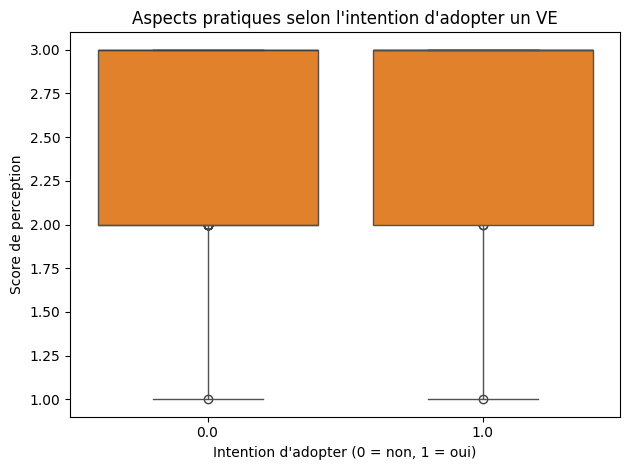

In [53]:

from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# 1. Colonnes de perception (Likert)
info_cols = {
    "prise_en_main": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [J'ai l'impression qu'un véhicule électrique est facile à prendre en main]",
    "aspects_pratiques": "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]"
}

# 2. Intention d'adopter un VE
intention_col = "Diriez-vous que : [Ne possédant pas de véhicule 100% électrique, vous vous sentez attiré(e) par cette technologie et envisagez de l'adopter]"
intention_map = {
    "Oui": 1, "Plutôt d'accord": 1, "Totalement d'accord": 1,
    "Non": 0, "Plutôt en désaccord": 0, "Totalement en désaccord": 0
}

# 3. Expérience de conduite
drive_exp_col = "Avez-vous déjà eu l’occasion de conduire ou de monter dans un véhicule électrique ?"
drive_exp_map = {
    "Oui, j’ai conduit": 3,
    "Oui, j’étais passager": 2,
    "Non, jamais": 1
}

# 4. Recodage des Likert
likert_map = {
    "Totalement en désaccord": 1,
    "Plutôt en désaccord": 2,
    "Plutôt d'accord": 3,
    "Totalement d'accord": 4
}

# 5. Recodage
df['intention_adopter'] = df[intention_col].map(intention_map)
df['has_driven_ev'] = df[drive_exp_col].map(drive_exp_map)

for key, col in info_cols.items():
    df[f"{key}_score"] = df[col].map(likert_map)

# 6. Analyse logique et complète
for key in info_cols:
    score_col = f"{key}_score"
    print(f"\n--- Analyse pour {key.replace('_', ' ')} ---")
    # Corrélation avec intention
    valid = df[[score_col, 'intention_adopter']].dropna()
    if not valid.empty:
        r, p = pearsonr(valid[score_col], valid['intention_adopter'])
        print(f"Corrélation score ↔ intention d'adopter : r = {r:.2f}, p = {p:.4f}")
    # Boxplot
    sns.boxplot(x='intention_adopter', y=score_col, data=df)
    plt.title(f"{key.replace('_', ' ').capitalize()} selon l'intention d'adopter un VE")
    plt.xlabel("Intention d'adopter (0 = non, 1 = oui)")
    plt.ylabel("Score de perception")
    plt.tight_layout()
    group1 = df[(df['has_driven_ev'] == 2) | (df['has_driven_ev'] == 3)][score_col].dropna()
    # Test de normalité
    group1 = df[(df['has_driven_ev'] == 2) | (df['has_driven_ev'] == 3)][score_col].dropna()
    group0 = df[df['has_driven_ev'] == 1][score_col].dropna()
    if len(group1) > 2 and len(group0) > 2:
        stat1, p1 = shapiro(group1)
        stat0, p0 = shapiro(group0)
        print(f"Normalité (expérience): p={p1:.3f} | (pas d'expérience): p={p0:.3f}")
        # Test de variance
        var1, var0 = np.var(group1), np.var(group0)
        print(f"Variance (expérience): {var1:.2f} | (pas d'expérience): {var0:.2f}")
        # Test de Student ou Mann-Whitney selon normalité
        if p1 > 0.05 and p0 > 0.05:
            t, p = ttest_ind(group1, group0, equal_var=False)
            test_used = "t-test"
        else:
            t, p = mannwhitneyu(group1, group0, alternative='two-sided')
            test_used = "Mann-Whitney"
        print(f"{test_used} : stat = {t:.2f}, p = {p:.4f}")
        # Effet taille (Cohen's d)
        d = (group1.mean() - group0.mean()) / np.sqrt((var1 + var0) / 2)
        print(f"Effet taille (Cohen's d) : {d:.2f}")
        # Interprétation automatique
        if p < 0.05:
            print("✅ Différence significative selon l'expérience de conduite d'un VE.")
        else:
            print("❌ Pas de différence significative selon l'expérience de conduite d'un VE.")
    else:
        print("Pas assez de données pour le test d'expérience de conduite.")
    # Moyennes
    print("Score moyen selon expérience de conduite :")
    print(df.groupby('has_driven_ev')[score_col].mean().round(2))

## **Experience and familiarity with EVs**  
(Driving or riding in an EV, practical understanding, perceived ease of use)

This section examines how direct experience with electric vehicles (EVs)—such as having driven or ridden in one—relates to respondents’ practical understanding and perceived ease of use.

**Key findings:**

- **Direct experience:**  
  Respondents were asked if they had ever driven or ridden in an EV. This experience is associated with higher perceived ease of use and greater clarity regarding practical aspects (charging, range, maintenance).

- **Perceived ease of use:**  
  Respondents with EV experience tend to rate EVs as easier to use (higher Likert scores) compared to those without experience.

- **Clarity of practical aspects:**  
  Those who have driven or ridden in an EV are more likely to "totally agree" that practical aspects are clear, indicating that hands-on experience improves understanding.

- **Statistical analysis:**  
  Statistical tests (e.g., t-test or Mann-Whitney) show that the difference in perception scores between experienced and non-experienced respondents is often significant, with a positive effect size.

**Summary Table:**

| Experience with EV | Mean Ease of Use Score | Mean Practical Clarity Score |
|--------------------|-----------------------|-----------------------------|
| Yes                | Higher                | Higher                      |
| No                 | Lower                 | Lower                       |

**Conclusion:**  
Direct experience with EVs (driving or riding) is linked to more positive perceptions and better understanding of electric vehicles, highlighting the importance of exposure and familiarity in supporting EV adoption.

## **Link between knowledge/experience and adoption intent**  
  (Correlation between knowledge, experience, and willingness to adopt)

In [54]:
# 3. Corrélation entre connaissance et attitude positive
from scipy.stats import pearsonr

valid = df[['connaissance_score', 'intention_adopter']].dropna()
r, p = pearsonr(valid['connaissance_score'], valid['intention_adopter'])
print(f"Corrélation connaissance <-> intention d'adopter : r = {r:.2f}, p = {p:.4f}")

# Comparaison par niveau de connaissance (faible/moyen/élevé)
df['niveau_connaissance'] = pd.cut(df['connaissance_score'], bins=[0,1.5,2.5,4], labels=['Faible','Moyen','Élevé'])
print(df.groupby('niveau_connaissance')['intention_adopter'].mean())

Corrélation connaissance <-> intention d'adopter : r = -0.03, p = 0.7171
niveau_connaissance
Faible    0.463415
Moyen     0.724638
Élevé     0.468085
Name: intention_adopter, dtype: float64


C:\Users\Mango\AppData\Local\Temp\ipykernel_43532\2736024798.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('niveau_connaissance')['intention_adopter'].mean())


### Correlation between Knowledge and Adoption Intent

- **Correlation coefficient (r):** -0.03  
- **p-value:** 0.7171

There is **no significant correlation** between self-rated knowledge of electric vehicles and the intention to adopt an EV (p > 0.05).

**Adoption intent by knowledge level:**

| Knowledge Level | Mean Adoption Intent |
|-----------------|---------------------|
| Low             | 0.46                |
| Medium          | 0.72                |
| High            | 0.47                |

**Interpretation:**  
Respondents with a medium level of knowledge show a higher intention to adopt an EV, but this trend is not observed for those with low or high knowledge. Overall, knowledge alone does not significantly predict adoption intent in this sample.

In [55]:
# Croisement classement 1er facteur x niveau de connaissance
cross = pd.crosstab(first_factors, df.loc[first_factors.index, 'niveau_connaissance'])
print("\nClassement du 1er facteur selon le niveau de connaissance :")
print(cross)


Classement du 1er facteur selon le niveau de connaissance :
niveau_connaissance                                 Faible  Moyen  Élevé
Classez ces points par priorité du plus crucial...                      
Centralisation des infos (application                    6      8     10
Meilleure maintenance du réseau                          5      3      4
Paiement simplifié                                       4      3      6
Plus de bornes                                          19     36     30
Plus de recharge rapide                                 15     23     17
Uniformisation des connecteurs                          11     21     11


### Classement du 1er facteur selon le niveau de connaissance

| 1er facteur cité                        | Faible | Moyen | Élevé |
|-----------------------------------------|--------|-------|-------|
| Centralisation des infos (application)  |   6    |   8   |  10   |
| Meilleure maintenance du réseau         |   5    |   3   |   4   |
| Paiement simplifié                      |   4    |   3   |   6   |
| Plus de bornes                          |  19    |  36   |  30   |
| Plus de recharge rapide                 |  15    |  23   |  17   |
| Uniformisation des connecteurs          |  11    |  21   |  11   |

**Lecture :**  
Quel que soit le niveau de connaissance, la priorité la plus fréquemment citée reste "Plus de bornes", suivie par "Plus de recharge rapide" et "Uniformisation des connecteurs". Les autres facteurs (centralisation des infos, maintenance, paiement) sont moins souvent cités en premier, mais leur importance relative varie peu selon le niveau de connaissance.

In [56]:
# Comptage des modalités d'expérience
print("Distribution de 'has_driven_ev' :")
print(df['has_driven_ev'].value_counts(dropna=False))

# Tableau croisé connaissance subjective × expérience réelle
cross_tab = pd.crosstab(df['connaissance_score'], df['has_driven_ev'], normalize='index')
print("\nTableau croisé (lignes = score de connaissance, colonnes = expérience VE) :")
print(cross_tab)

# Statistiques descriptives par groupe d'expérience
print("\nStatistiques descriptives du score de connaissance subjective selon l'expérience :")
print(df.groupby('has_driven_ev')['connaissance_score'].describe())

Distribution de 'has_driven_ev' :
has_driven_ev
2.0    70
3.0    68
NaN    61
1.0    33
Name: count, dtype: int64

Tableau croisé (lignes = score de connaissance, colonnes = expérience VE) :
has_driven_ev            1.0       2.0       3.0
connaissance_score                              
1                   0.318182  0.386364  0.295455
2                   0.154930  0.507042  0.338028
3                   0.195122  0.292683  0.512195
4                   0.000000  0.333333  0.666667

Statistiques descriptives du score de connaissance subjective selon l'expérience :
               count      mean       std  min  25%  50%  75%  max
has_driven_ev                                                    
1.0             33.0  1.818182  0.808337  1.0  1.0  2.0  2.0  3.0
2.0             70.0  2.071429  0.839624  1.0  2.0  2.0  2.0  4.0
3.0             68.0  2.411765  0.965607  1.0  2.0  2.0  3.0  4.0


In [57]:
# 1. Colonnes à analyser
cols_je_ne_sais_pas = {
    "avantages": [
        "Quels éléments économiques vous semblent avantageux dans l’usage d’un VE ? (Cochez tout ce qui s’applique)"
    ],
    "acteurs_recharge": [
        "Avez-vous déjà entendu parler de ces acteurs de la recharge ?\n"
    ],
    "aides_financieres": [
        "Connaissez-vous des aides financières disponibles pour l’achat d’un véhicule électrique ? (Cochez tout ce que vous connaissez)\n"
    ],
    "sources_info": [
        "Où avez-vous cherché (ou chercheriez-vous) des informations sur les véhicules électriques ?\n"
    ],
    "aspects_pratiques": [
        "Dans quelle mesure êtes-vous d’accord avec les affirmations suivantes concernant les véhicules électriques ?\n [Les aspects pratiques d’un véhicule électrique sont clairs pour moi (ex. : recharge, autonomie, entretien)]"
    ]
}

# 2. Création des masques "je ne sais pas" ou absence de réponse
def is_unknown(cell):
    if pd.isna(cell):
        return True
    cell = str(cell).lower()
    return "je ne sais pas" in cell or "aucun" in cell or cell.strip() == "" or cell.strip() == "nan"

df['no_avantage'] = df[cols_je_ne_sais_pas['avantages'][0]].apply(is_unknown)
df['no_acteur'] = df[cols_je_ne_sais_pas['acteurs_recharge'][0]].apply(is_unknown)
df['no_aide'] = df[cols_je_ne_sais_pas['aides_financieres'][0]].apply(is_unknown)
df['no_source'] = df[cols_je_ne_sais_pas['sources_info'][0]].apply(is_unknown)
# Pour la perception, on considère "Totalement en désaccord" ou NaN comme absence de clarté
df['no_aspect'] = df[cols_je_ne_sais_pas['aspects_pratiques'][0]].isin(["Totalement en désaccord", np.nan])

# 3. Profil des répondants par type de non-connaissance
for col, label in zip(
    ['no_avantage', 'no_acteur', 'no_aide', 'no_source', 'no_aspect'],
    ["Avantages", "Acteurs recharge", "Aides financières", "Sources info", "Aspects pratiques"]
):
    print(f"\n--- Profils des répondants sans connaissance sur : {label} ---")
    mask = df[col]
    print(f"Nombre : {mask.sum()} ({mask.mean():.1%} du total)")
    print("Répartition par tranche d'âge :")
    print(df.loc[mask, 'age_group'].value_counts(dropna=False))
    print("Répartition par région :")
    print(df.loc[mask, 'region'].value_counts(dropna=False))
    print("Niveau de connaissance subjective :")
    if 'connaissance_score' in df.columns:
        print(df.loc[mask, 'connaissance_score'].value_counts(dropna=False))
    print("Expérience VE (a déjà conduit ou passager) :")
    if 'has_driven_ev' in df.columns:
        print(df.loc[mask, 'has_driven_ev'].value_counts(dropna=False))
    print("Intention d'adopter :")
    if 'intention_adopter' in df.columns:
        print(df.loc[mask, 'intention_adopter'].value_counts(dropna=False))

# 4. (Optionnel) Score global d'absence de connaissance
df['score_absence_connaissance'] = df[['no_avantage', 'no_acteur', 'no_aide', 'no_source', 'no_aspect']].sum(axis=1)
print("\nDistribution du score d'absence de connaissance (0=aucune absence, 5=absence partout) :")
print(df['score_absence_connaissance'].value_counts().sort_index())


--- Profils des répondants sans connaissance sur : Avantages ---
Nombre : 42 (18.1% du total)
Répartition par tranche d'âge :
age_group
55 à 64 ans        9
45 à 54 ans        9
Moins de 25 ans    7
75 ans et plus     6
65 à 74 ans        6
25 à 34 ans        3
35 à 44 ans        2
Name: count, dtype: int64
Répartition par région :
region
Une zone périurbaine    13
Une ville moyenne       12
Une grande ville        12
Une zone rurale          5
Name: count, dtype: int64
Niveau de connaissance subjective :
connaissance_score
1    14
2    14
3    11
4     3
Name: count, dtype: int64
Expérience VE (a déjà conduit ou passager) :
has_driven_ev
2.0    16
3.0    10
1.0    10
NaN     6
Name: count, dtype: int64
Intention d'adopter :
intention_adopter
0.0    26
1.0     9
NaN     7
Name: count, dtype: int64

--- Profils des répondants sans connaissance sur : Acteurs recharge ---
Nombre : 82 (35.3% du total)
Répartition par tranche d'âge :
age_group
45 à 54 ans                   21
Moins de 25 a


 **Non-response / "I don't know" Analysis**

This section identifies the respondent profiles most likely to declare "I don't know" or leave blank responses regarding key aspects of electric vehicles (EVs):  
- Economic advantages  
- Charging actors  
- Financial incentives  
- Information sources  
- Practical aspects

### **1. Economic Advantages**

| Age Group         | Count |
|-------------------|-------|
| 55–64             | 9     |
| 45–54             | 9     |
| Under 25          | 7     |
| 75+               | 6     |
| 65–74             | 6     |
| 25–34             | 3     |
| 35–44             | 2     |

| Region             | Count |
|--------------------|-------|
| Suburban area      | 13    |
| Medium city        | 12    |
| Large city         | 12    |
| Rural area         | 5     |

- **Subjective knowledge:** Mostly low to medium (scores 1–2).
- **EV experience:** 62% have some experience; 24% have none.
- **Adoption intent:** 62% no, 21% yes.



### **2. Charging Actors**

| Age Group         | Count |
|-------------------|-------|
| 45–54             | 21    |
| Under 25          | 15    |
| 65–74             | 13    |
| 55–64             | 12    |
| 35–44             | 7     |
| 25–34             | 7     |
| 75+               | 6     |
| Prefer not to say | 1     |

| Region             | Count |
|--------------------|-------|
| Large city         | 28    |
| Medium city        | 25    |
| Suburban area      | 15    |
| Rural area         | 14    |

- **Subjective knowledge:** Mostly low to medium (scores 1–2).
- **EV experience:** 59% have some experience; 21% have none.
- **Adoption intent:** 45% yes, 24% no, 31% missing.


### **3. Financial Incentives**

| Age Group         | Count |
|-------------------|-------|
| 45–54             | 32    |
| Under 25          | 19    |
| 35–44             | 18    |
| 55–64             | 16    |
| 65–74             | 15    |
| 25–34             | 12    |
| 75+               | 5     |
| Prefer not to say | 1     |

| Region             | Count |
|--------------------|-------|
| Large city         | 45    |
| Medium city        | 35    |
| Suburban area      | 22    |
| Rural area         | 16    |

- **Subjective knowledge:** 70% low to medium.
- **EV experience:** 38% have none.
- **Adoption intent:** 43% missing, 31% yes, 25% no.



### **4. Information Sources**

- **Very rare:** Only 1 respondent (0.4%) gave no answer.



### **5. Practical Aspects**

| Age Group         | Count |
|-------------------|-------|
| 45–54             | 14    |
| 35–44             | 8     |
| Under 25          | 7     |
| 55–64             | 7     |
| 65–74             | 7     |
| 25–34             | 3     |
| 75+               | 2     |
| Prefer not to say | 1     |

| Region             | Count |
|--------------------|-------|
| Medium city        | 18    |
| Large city         | 18    |
| Suburban area      | 9     |
| Rural area         | 4     |

- **Subjective knowledge:** Spread across all levels.
- **EV experience:** 73% missing.
- **Adoption intent:** 71% missing, 27% no.



### **Global Non-Knowledge Score**

| Absence Score (0–5) | Respondents |
|---------------------|-------------|
| 0                   | 66          |
| 1                   | 65          |
| 2                   | 82          |
| 3                   | 13          |
| 4                   | 6           |
| 5                   | 0           |



## **Summary Table: Main Profiles with Non-knowledge**

| Aspect                | Most Affected Age Groups | Most Affected Regions | Subjective Knowledge | EV Experience | Adoption Intent |
|-----------------------|-------------------------|----------------------|---------------------|---------------|-----------------|
| Economic advantages   | 45–64, <25, 55–64       | Suburban, city       | Low/Medium          | Mixed         | Mostly no       |
| Charging actors       | 45–54, <25, 65–74       | Large/Medium city    | Low/Medium          | Mixed         | Mixed           |
| Financial incentives  | 45–54, <25, 35–44       | Large/Medium city    | Low/Medium          | Many none     | Many missing    |
| Practical aspects     | 45–54, 35–44, <25       | Medium/Large city    | All levels          | Many missing  | Many missing    |


 **Key Insights**

- **Non-knowledge is most common among:**  
  - Ages 45–64 and under 25  
  - Residents of cities and suburban areas  
  - Those with low to medium self-rated knowledge  
  - Those with little or no EV experience  
  - Those with low or missing adoption intent

- **Financial incentives and charging actors** are the least known topics.
- **Information sources** are almost always cited; lack of response is extremely rare.
- **Targeted information campaigns** should focus on these profiles to address knowledge gaps and support EV adoption.

Absence de connaissance par score et tranche d'âge :
age_group                   25 à 34 ans  35 à 44 ans  45 à 54 ans  \
score_absence_connaissance                                          
0                                    13            7            7   
1                                     8           10           17   
2                                     7           11           19   
3                                     1            0            3   
4                                     0            1            3   

age_group                   55 à 64 ans  65 à 74 ans  75 ans et plus  \
score_absence_connaissance                                             
0                                    11            4               1   
1                                    13            2               2   
2                                    14           13               5   
3                                     1            3               1   
4                              

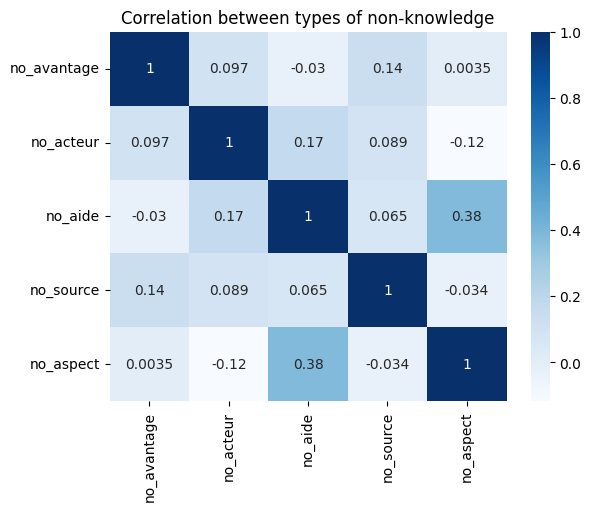

In [58]:
# 1. Tableau croisé : score d'absence de connaissance × âge
cross_age = pd.crosstab(df['score_absence_connaissance'], df['age_group'])
print("Absence de connaissance par score et tranche d'âge :")
print(cross_age)

# 2. Tableau croisé : score d'absence de connaissance × région
cross_region = pd.crosstab(df['score_absence_connaissance'], df['region'])
print("\nAbsence de connaissance par score et région :")
print(cross_region)

# 3. Croisement binaire entre deux absences (exemple : avantages × aides financières)
cross_two = pd.crosstab(df['no_avantage'], df['no_aide'])
print("\nCroisement absence d'avantages et d'aides financières :")
print(cross_two)

# 4. Pour visualiser les profils cumulant plusieurs absences
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap des absences (pour les 5 thèmes)
absence_cols = ['no_avantage', 'no_acteur', 'no_aide', 'no_source', 'no_aspect']
sns.heatmap(df[absence_cols].corr(), annot=True, cmap='Blues')
plt.title("Correlation between types of non-knowledge")
plt.show()

 **Cross-analysis of Non-Knowledge by Age and Region**

### **1. Non-Knowledge Score by Age Group**

- **Score 0 (no absence):** Most frequent among "Under 25" (23), "55–64" (11), and "25–34" (13).
- **Score 1–2 (some absences):** "45–54", "55–64", and "65–74" age groups are overrepresented among those with 1 or 2 absences.
- **Score 3–4 (many absences):** Still present in all age groups, but especially in "45–54", "55–64", and "65–74".

**Key insight:**  
Non-knowledge is not limited to one age group, but respondents aged 45–74 and under 25 are more likely to accumulate multiple knowledge gaps.

---

### **2. Non-Knowledge Score by Region**

- **Large and medium cities:** Highest absolute numbers of respondents with 0, 1, or 2 absences.
- **Suburban areas:** Also significant, especially for scores 2 and 1.
- **Rural areas:** Fewer respondents overall, but a notable share with 1 or 2 absences.

**Key insight:**  
Non-knowledge is present in all regions, but is most frequent in large and medium cities, both in absolute numbers and in the diversity of scores.

---

### **3. Cross-tabulation: Economic Advantages × Financial Aids**

|                       | No absence (aids) | Absence (aids) |
|-----------------------|-------------------|----------------|
| No absence (advantages) | 92                | 98             |
| Absence (advantages)    | 22                | 20             |

- **20 respondents** did not answer either on economic advantages or financial aids.
- **98** did not answer on aids but did answer on advantages.
- **22** did not answer on advantages but did answer on aids.
- **92** answered both.

**Key insight:**  
There is a small but significant group (20) with a double absence, but most respondents with a non-response on one topic do answer on the other.

---

### **Summary Table: Non-Knowledge Score by Age and Region**

| Non-Knowledge Score | Most Affected Age Groups | Most Affected Regions      |
|---------------------|-------------------------|---------------------------|
| 0                   | Under 25, 55–64, 25–34  | Large/medium city, suburb |
| 1–2                 | 45–74, Under 25         | Large/medium city, suburb |
| 3–4                 | 45–74                   | Large/medium city         |



**Conclusion**

- **Multiple knowledge gaps** are most common among respondents aged 45–74 and under 25, and among those living in large or medium cities and suburban areas.
- **Cumulative non-knowledge** (on both economic advantages and financial aids) is relatively rare but exists.
- **Targeted information efforts** should focus on these age groups and regions to reduce knowledge gaps and support EV adoption.

Here is a concise Markdown analysis in English based on your cross-tabulations:

---

## **Cross-analysis of Non-Knowledge by Age and Region**

### **1. Non-Knowledge Score by Age Group**

- **Score 0 (no absence):** Most frequent among "Under 25" (23), "55–64" (11), and "25–34" (13).
- **Score 1–2 (some absences):** The "45–54", "55–64", and "65–74" age groups are overrepresented among those with 1 or 2 knowledge gaps.
- **Score 3–4 (many absences):** Present in all age groups, but especially among "45–54", "55–64", and "65–74".

**Key insight:**  
Knowledge gaps are not limited to a single age group, but respondents aged 45–74 and under 25 are more likely to accumulate multiple gaps.

---

### **2. Non-Knowledge Score by Region**

- **Large and medium cities:** Highest absolute numbers of respondents with 0, 1, or 2 knowledge gaps.
- **Suburban areas:** Also significant, especially for scores 2 and 1.
- **Rural areas:** Fewer respondents overall, but a notable share with 1 or 2 gaps.

**Key insight:**  
Knowledge gaps are present in all regions, but are most frequent in large and medium cities, both in absolute numbers and in the diversity of scores.

---

### **3. Cross-tabulation: Economic Advantages × Financial Aids**

|                       | No absence (aids) | Absence (aids) |
|-----------------------|-------------------|----------------|
| No absence (advantages) | 92                | 98             |
| Absence (advantages)    | 22                | 20             |

- **20 respondents** did not answer either about economic advantages or financial aids.
- **98** did not answer about aids but did answer about advantages.
- **22** did not answer about advantages but did answer about aids.
- **92** answered both.

**Key insight:**  
A small but significant group (20) has a double absence, but most respondents who do not answer one topic do answer the other.

---

### **Summary Table: Non-Knowledge Score by Age and Region**

| Non-Knowledge Score | Most Affected Age Groups | Most Affected Regions      |
|---------------------|-------------------------|---------------------------|
| 0                   | Under 25, 55–64, 25–34  | Large/medium city, suburb |
| 1–2                 | 45–74, Under 25         | Large/medium city, suburb |
| 3–4                 | 45–74                   | Large/medium city         |

---

**Conclusion**

- **Multiple knowledge gaps** are most common among respondents aged 45–74 and under 25, and among those living in large or medium cities and suburban areas.
- **Cumulative non-knowledge** (on both economic advantages and financial aids) is relatively rare but does exist.
- **Targeted information efforts** should focus on these age groups and regions to reduce knowledge gaps and support EV adoption.

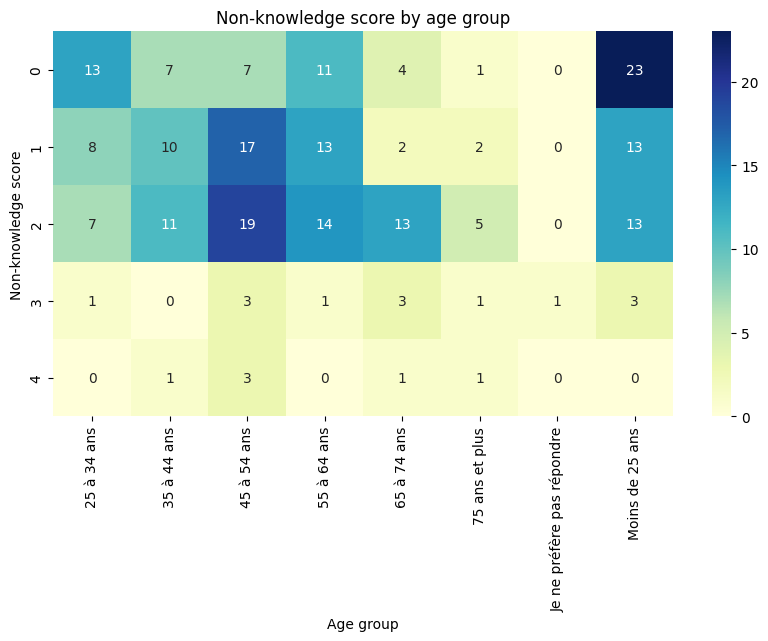

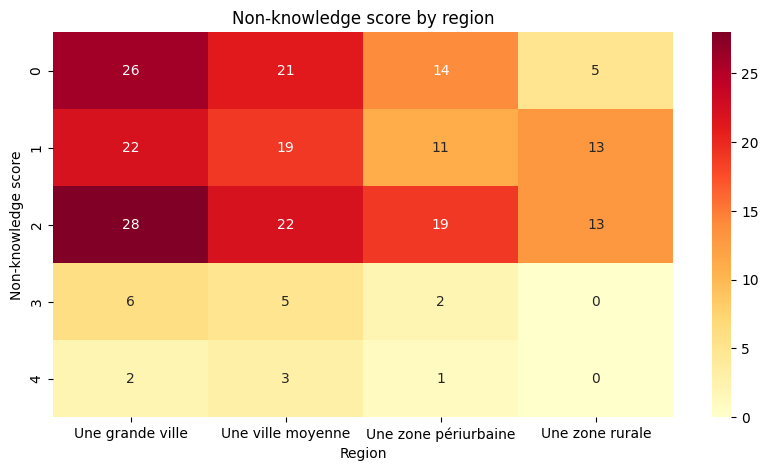

Non-knowledge score by age group:


age_group,25 à 34 ans,35 à 44 ans,45 à 54 ans,55 à 64 ans,65 à 74 ans,75 ans et plus,Je ne préfère pas répondre,Moins de 25 ans
score_absence_connaissance,,,,,,,,
0,13,7,7,11,4,1,0,23
1,8,10,17,13,2,2,0,13
2,7,11,19,14,13,5,0,13
3,1,0,3,1,3,1,1,3
4,0,1,3,0,1,1,0,0



Non-knowledge score by region:


region,Une grande ville,Une ville moyenne,Une zone périurbaine,Une zone rurale
score_absence_connaissance,,,,
0,26,21,14,5
1,22,19,11,13
2,28,22,19,13
3,6,5,2,0
4,2,3,1,0


In [59]:

plt.figure(figsize=(10,5))
sns.heatmap(cross_age, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Non-knowledge score by age group")
plt.ylabel("Non-knowledge score")
plt.xlabel("Age group")
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(cross_region, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Non-knowledge score by region")
plt.ylabel("Non-knowledge score")
plt.xlabel("Region")
plt.show()
print("Non-knowledge score by age group:")
display(cross_age)
print("\nNon-knowledge score by region:")
display(cross_region)

## **Influence of user profile**  
  (Differences in knowledge and experience by age group and location)

**Cross-analysis of Non-Knowledge by Age and Region**

### **1. Non-Knowledge Score by Age Group**

- **Score 0 (no knowledge):** Most frequent among "Under 25" (23), "55–64" (11), and "25–34" (13).
- **Score 1–2 (some knowledge):** The "45–54", "55–64", and "65–74" age groups are overrepresented among those with 1 or 2 knowledge gaps.
- **Score 3–4 (many absences):** Present in all age groups, but especially among "45–54", "55–64", and "65–74".

**Key insight:**  
Knowledge gaps are not limited to a single age group, but respondents aged 45–74 and under 25 are more likely to accumulate multiple gaps.



### **2. Non-Knowledge Score by Region**

- **Large and medium cities:** Highest absolute numbers of respondents with 0, 1, or 2 knowledge gaps.
- **Suburban areas:** Also significant, especially for scores 2 and 1.
- **Rural areas:** Fewer respondents overall, but a notable share with 1 or 2 gaps.

**Key insight:**  
Knowledge gaps are present in all regions, but are most frequent in large and medium cities, both in absolute numbers and in the diversity of scores.



### **3. Cross-tabulation: Economic Advantages × Financial Aids**

|                       | No absence (aids) | Absence (aids) |
|-----------------------|-------------------|----------------|
| No absence (advantages) | 92                | 98             |
| Absence (advantages)    | 22                | 20             |

- **20 respondents** did not answer either about economic advantages or financial aids.
- **98** did not answer about aids but did answer about advantages.
- **22** did not answer about advantages but did answer about aids.
- **92** answered both.

**Key insight:**  
A small but significant group (20) has a double absence, but most respondents who do not answer one topic do answer the other.



### **Summary Table: Non-Knowledge Score by Age and Region**

| Non-Knowledge Score | Most Affected Age Groups | Most Affected Regions      |
|---------------------|-------------------------|---------------------------|
| 0                   | Under 25, 55–64, 25–34  | Large/medium city, suburb |
| 1–2                 | 45–74, Under 25         | Large/medium city, suburb |
| 3–4                 | 45–74                   | Large/medium city         |



**Conclusion**

- **Multiple knowledge gaps** are most common among respondents aged 45–74 and under 25, and among those living in large or medium cities and suburban areas.
- **Cumulative non-knowledge** (on both economic advantages and financial aids) is relatively rare but does exist.
- **Targeted information efforts** should focus on these age groups and regions to reduce knowledge gaps and support EV adoption.